## Calculate scaling factor to put a and b on same scale
This version runs on intcorr output from Xgremlin.
Using all lines above given SNR, regardless of identification

In [1]:
file1 = "Fe042222a.001.intcorr"
file2 = "Fe042222b.001.intcorr"
SNR= 50

Mean: 0.3701 Std. Dev: 0.0158 from 42 values; 0 outliers rejected



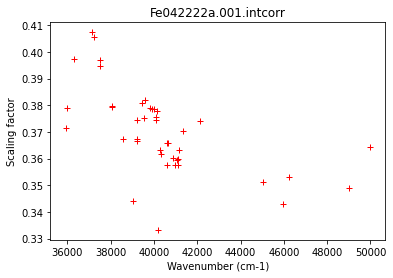

In [2]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt


afile = open(file1)
bfile = open(file2)

wnum=[]
inten=[]
wnumplot = []
ratio_ab = []

def reject_outliers(data):
    return data[abs(data - np.mean(data)) < 3 * np.std(data)]

for line in afile:
    line=line.split()
    if line[0].isnumeric():
        if float(line[2]) > SNR :
            wnum.append(float(line[1]))
            inten.append(float(line[5]))

for line in bfile:
    line=line.split()
    if line[0].isnumeric():
        if float(line[2])> SNR:
            wnumb = float(line[1])
            intenb = float(line[5])
            for i in wnum:
                if -0.2< wnumb-i <0.2:
                    inten_ratio = inten[wnum.index(i)]/intenb
                    wnumplot.append(wnumb)
                    ratio_ab.append(inten_ratio)
#                    print( "%10.4f %6.4f " % (wnumb, inten_ratio))


data_rej = reject_outliers(np.array(ratio_ab))
scale_mean = np.mean(data_rej)
scale_std = np.std(data_rej)
print ("Mean: %6.4f Std. Dev: %6.4f from %d values; %d outliers rejected\n" % (scale_mean, scale_std, len(data_rej), len(ratio_ab)-len(data_rej) ))

fig,ax=plt.subplots()
ax.plot(wnumplot,ratio_ab,'r+')
ax.set(xlabel="Wavenumber (cm-1)",ylabel = "Scaling factor",title = file1)
plt.show()

No significant slope on this plot and the standard deviation looks OK

### Scale detector B to detector A and combine the two detectors using weighted mean

Use the square of the SNR as the weighting factor. Cap the SNR at 100 so that strong lines seen in both detectors are equally weighted.

In [3]:
import numpy as np

afile = open("Fe042222a.001.intcorr")
bfile = open("Fe042222b.001.intcorr")
outfile = open("Fe042222.001.combined",'w')

wnum=[]
inten=[]
wt=[]
outline=[]
fwhm=[]

# print("Scaling factor: ",scale_mean)
# print("Wavenumber     SNR     FWHM    Inten")

for line in afile:
    line=line.split()
    if line[0].isnumeric():
        wnum.append(float(line[1]))
        inten.append(float(line[5]))
        wt.append(min(10000,(float(line[2])**2)))  # Set max. SNR of 100
        fwhm.append(line[3])

prt=0
for line in bfile:
    line=line.split()
    if line[0].isnumeric():
        wnumb = float(line[1])
        intenb = scale_mean*float(line[5])
        mtc=0

        for i in wnum:
            if -0.2< wnumb-i <0.2:
                mtc=1
                idx=wnum.index(i)
                weight=min(10000,float(line[2])**2)  # Set max. SNR of 100
                awt=wt[wnum.index(i)]                # Weight from detector A
                
                aveinten=np.average([intenb,inten[idx]],weights=(weight,awt))   #Weighted mean intensity
# Calculate standard deviation based on minimum of next two functions. See Liggins, ApJS 252, 10 for details.             
                std1=np.sqrt(np.average(((intenb-aveinten)**2,(inten[idx]-aveinten)**2), weights=(weight,awt)))
                std2=aveinten/np.sqrt(weight+awt)
                stdinten=max(std1,std2)
#                print("%10.4f %6d %6d   %6d %6.0f  " %(wnumb,intenb,inten[idx],aveinten,aveinten/stdinten))
                outline.append((wnumb,aveinten/stdinten,line[3],aveinten))
                prt+=1
# Delete the ones we've used
                del inten[idx]
                del wt[idx]
                del wnum[idx]
                del fwhm[idx]

# Add the ones from detector B that didn't match to the output array
        if mtc==0:
#            print("%10.4f        %6d            %4.0f" %(wnumb,intenb,min(100,float(line[2]))))
            outline.append((wnumb,min(100,float(line[2])),line[3],intenb))
            prt+=1

        # And then the ones from detector A that didn't match - the ones left after deleting the matching ones
for i in wnum:
    idx=wnum.index(i)
#    print("%10.4f %6d                   %4.0f" %(i,inten[idx],min(100,wt[idx])))
    outline.append((i,min(100,np.sqrt(wt[idx])),fwhm[idx],inten[idx]))
    prt+=1
outline.sort()

# Write the lines out to the new .intcorr file
n=0
for i in outline:
#    print ("%10.4f     %3d     %4d  %7d" % ( i[0],i[1],float(i[2]),i[3]))
    outfile.write("%3d %10.4f     %3d     %4d   - %7d\n" % ( n,i[0],i[1],float(i[2]),i[3]))
    n+=1

outfile.close()

### Now match everything up to identifications

In [4]:
import math
 
brfile= open("Fe042222.001.combined")
outfile= open("Fe042222c.001.II",'w')
idfile = open("FeII.GN")

resoln = 0.1
wlow = 40000.
whi = 66000.

In [5]:
outfile.write("%s %s %s\n" % (resoln, wlow, whi))

idlow=[]
elow=[]
idupp=[]
eupp=[]
wl=[]

for line in idfile:
    line=line.split()
    idlow.append(line[6])
    elow.append(line[6])
    idupp.append(line[7])
    eupp.append(line[7])

    wl.append(line[4])

for line in brfile:
  line=line.split()
  if str.isdigit(line[0]):
    wno = float(line[1])
    snr = line[2]
    fwhm = line[3]
    inten = line[5]
#    wlen = float(line[15])*10.
    wlen = 1e8/wno
#    print(wno,snr,fwhm,inten)
    for wavel in wl:
        if -0.25  < float(wavel) - wno < 0.25 :
            idl = idlow[wl.index(wavel)]
            idu = idupp[wl.index(wavel)]
            outfile.write("%-5.0f %6.0f  %7.2f %8.3f  %10.3f   II   %s - %s\n" % (float(snr),float(inten),float(fwhm),wlen,wno,idl,idu))

outfile.close()


## Calculate the wavenumber correction factors

Mean: -1.97e-06 +- 1.66e-08 from 85 values; 1 outliers rejected



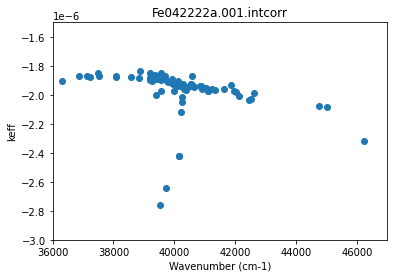

In [6]:
import numpy as np
import matplotlib.pyplot as plt

file1="Fe042222a.001.intcorr"
afile = open(file1)
calfile = open("fe.wcal")

def reject_outliers(data):
    return data[abs(data - np.mean(data)) < 3 * np.std(data)]

wl=[]
wlen = []
wdiff=[]

for line in calfile:
    line=line.split()
    wl.append(float(line[0]))
        
for line in afile:
    line=line.split()
    try:
        wsig = float(line[1])
    except:
        continue
#    print (wsig,float(line[2]))
    if float(line[2]) > 100:
        for i in wl:
            if -0.25 < wsig-i < 0.25:
                wlen.append(wsig)
                wdiff.append((wsig-i)/wsig)
        
data_rej = reject_outliers(np.array(wdiff))
scale_mean = np.mean(data_rej)
scale_std = np.std(data_rej)/np.sqrt(len(wdiff))
print ("Mean: %6.2e +- %6.2e from %d values; %d outliers rejected\n" % (scale_mean, scale_std, len(wdiff), len(wdiff)-len(data_rej) ))

plt.axes(ylim=[-3e-6,-1.5e-6],xlim=[36000,47000])
plt.scatter(wlen,wdiff)
plt.xlabel("Wavenumber (cm-1)")
plt.ylabel("keff")
plt.title(file1)
plt.show()

There is a significant slope on this plot. This would make it hard to use it for separation of blends using C of G. Perhaps it would work if the local wavenumber correction is applied.

Mean: -3.06e-06 +- 3.33e-08 from 28 values; 1 outliers rejected



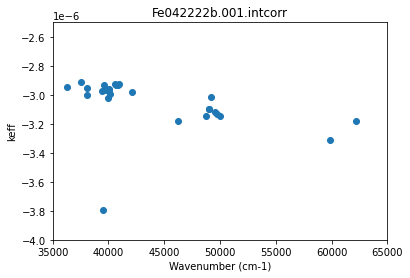

In [7]:
import numpy as np
import matplotlib.pyplot as plt

file1="Fe042222b.001.intcorr"
afile = open(file1)
calfile = open("fe.wcal")

def reject_outliers(data):
    return data[abs(data - np.mean(data)) < 3 * np.std(data)]

wl=[]
wlen = []
wdiff=[]

for line in calfile:
    line=line.split()
    wl.append(float(line[0]))
        
for line in afile:
    line=line.split()
    try:
        wsig = float(line[1])
    except:
        continue
#    print (wsig,float(line[2]))
    if float(line[2]) > 100:
        for i in wl:
            if -0.25 < wsig-i < 0.25:
                wlen.append(wsig)
                wdiff.append((wsig-i)/wsig)
        
data_rej = reject_outliers(np.array(wdiff))
scale_mean = np.average(data_rej)#,weights=wt)
scale_std = np.std(data_rej)/np.sqrt(len(wdiff))
print ("Mean: %6.2e +- %6.2e from %d values; %d outliers rejected\n" % (scale_mean, scale_std, len(wdiff), len(wdiff)-len(data_rej) ))

plt.axes(ylim=[-4e-6,-2.5e-6],xlim=[35000,65000])
plt.scatter(wlen,wdiff)
plt.xlabel("Wavenumber (cm-1)")
plt.ylabel("keff")
plt.title(file1)
plt.show()

A similar slope is seen on this plot, making it hard to use for separation of blends.